# MAT281 - Laboratorio N°11

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [1]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import random
from matplotlib.colors import rgb_to_hsv
from statsmodels.tsa.statespace.sarimax import SARIMAX
from metrics_regression import *


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv(os.path.join("data","interventionscitoyendo.csv"), sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date_str'] = df['date'].apply(lambda x: x[:7])
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude,date_str
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,2018-09
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,2018-04
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122,2018-09
3,Méfait,2017-07-21,jour,21.0,0.000000,0.000000e+00,-76.237290,0.000000,2017-07
4,Méfait,2017-07-29,jour,12.0,0.000000,0.000000e+00,-76.237290,0.000000,2017-07


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y crearemos un nuevo conjuntos de datos llamados `df_week`.

In [3]:
df['weekofyear'] = df['date'].dt.week
df['year'] =  df['date'].dt.year

df_week = df.groupby(['categorie','weekofyear','year'])['pdq'].sum().reset_index()
dates = df_week.year*100+df_week.weekofyear
df_week['date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
df_week.head()

<ipython-input-3-171270f4f4f6>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.week


,categorie,weekofyear,year,pdq,date
0,Introduction,1,2015,2077.0,2015-01-11
1,Introduction,1,2016,4412.0,2016-01-10
2,Introduction,1,2017,5254.0,2017-01-08
3,Introduction,1,2018,3242.0,2018-01-07
4,Introduction,1,2019,3938.0,2019-01-13


El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Para cada categoría grafique la serie temporal correspondiente (columna `categorie`).
2. Elegir una categoría dentro de `validate_categorie`, luego cree el conjunto de datos llamado `df_categorie`.
3. Realice un análisis exploratorio de la serie temporal escogida.
4. Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
5. Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.


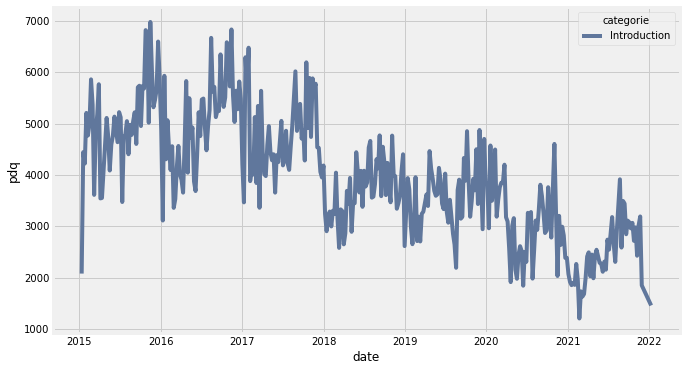

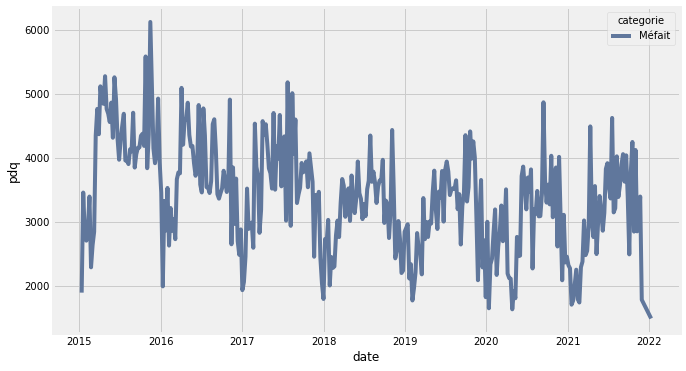

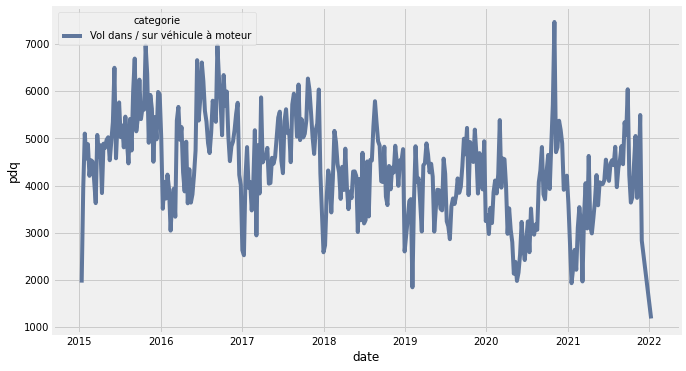

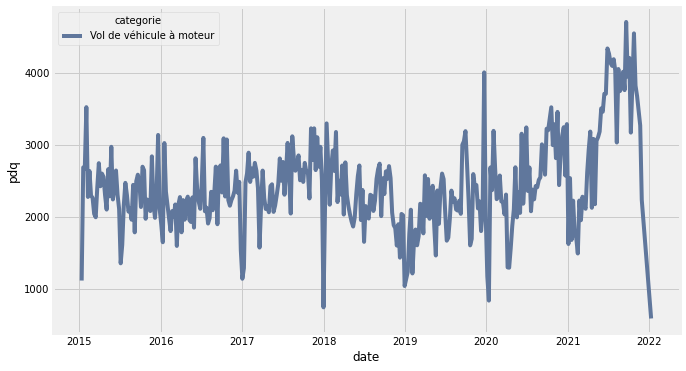

In [4]:
for cat in validate_categorie:
    mask= lambda df: (df["categorie"] == cat)
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        x='date',
        y='pdq',
        hue='categorie',
        data=df_week[mask],
        ci = None
    )
    plt.show()


In [5]:
random.seed(666)
categorie = validate_categorie[random.randint(0,3)]

In [6]:
mask = lambda df: df["categorie"] == categorie
df_categorie = df_week[mask]
df_categorie.head()

,categorie,weekofyear,year,pdq,date
1089,Vol de véhicule à moteur,1,2015,1114.0,2015-01-11
1090,Vol de véhicule à moteur,1,2016,2554.0,2016-01-10
1091,Vol de véhicule à moteur,1,2017,1884.0,2017-01-08
1092,Vol de véhicule à moteur,1,2018,2157.0,2018-01-07
1093,Vol de véhicule à moteur,1,2019,1235.0,2019-01-13


In [7]:
#Exploracion de datos


# Resumen de la informacion

def resumen_por_columna(df,cols):
    pd_series = df[cols]
    
    # elementos distintos 
    l_unique = pd_series.unique()
    
    # elementos vacios
    
    l_vacios = pd_series[pd_series.isna()]
    
    df_info = pd.DataFrame({
        'columna': [cols],
        'unicos': [len(l_unique)],
        'vacios': [len(l_vacios)]
    })
    
    return df_info

#exploracion de datos nulos

frames = []

for col in df_categorie.columns:
    aux_df = resumen_por_columna(df_categorie,col)
    frames.append(aux_df)
    
df_info = pd.concat(frames).reset_index(drop=True)
df_info

,columna,unicos,vacios
0,categorie,1,0
1,weekofyear,53,0
2,year,7,0
3,pdq,326,0
4,date,360,0


In [8]:
#revisar la integridad de la columna year

df_categorie["year"].unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [9]:
#eliminar datos donde el año no coincide con la fecha


mask = lambda df: df["year"] == df["date"].dt.year
df_categorie = df_categorie[mask]
df_categorie

,categorie,weekofyear,year,pdq,date
1089,Vol de véhicule à moteur,1,2015,1114.0,2015-01-11
1090,Vol de véhicule à moteur,1,2016,2554.0,2016-01-10
1091,Vol de véhicule à moteur,1,2017,1884.0,2017-01-08
1092,Vol de véhicule à moteur,1,2018,2157.0,2018-01-07
1093,Vol de véhicule à moteur,1,2019,1235.0,2019-01-13
...,...,...,...,...,...
1439,Vol de véhicule à moteur,51,2018,2023.0,2018-12-23
1440,Vol de véhicule à moteur,51,2019,1999.0,2019-12-29
1441,Vol de véhicule à moteur,51,2020,3292.0,2020-12-27
1444,Vol de véhicule à moteur,52,2017,741.0,2017-12-31


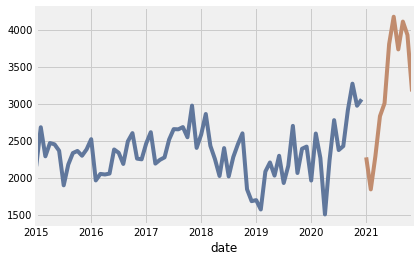

In [10]:
#modelo de pronostico

df_y = df_categorie[["pdq","date"]].set_index('date').resample('M').mean()

target_date = "2021-01-01"

mask_ds = df_y.index < target_date

y_train = df_y[mask_ds]
y_test = df_y[~mask_ds]

#plotting the data
y_train["pdq"].plot()
y_test["pdq"].plot()
plt.show()

In [11]:
#definir clase para automatizar el proceso

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

In [12]:
# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [13]:
# iterar para los distintos escenarios

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(df_y,target_date)
        frames.append(df_metrics)

    except:
        pass

In [14]:
# juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,521.0798,3.840949e+05,619.7539,0.1825,0.1757,0.1629,0.1824,0.1709,"SARIMA_(0,1,1)X(1,1,0,12)"
0,525.1247,3.926308e+05,626.6026,0.1800,0.1739,0.1641,0.1799,0.1716,"SARIMA_(1,1,1)X(1,1,0,12)"
0,542.3996,4.007551e+05,633.0522,0.1998,0.1907,0.1695,0.1998,0.1796,"SARIMA_(1,1,0)X(1,1,0,12)"
0,551.2923,4.187760e+05,647.1291,0.2065,0.1963,0.1723,0.2064,0.1829,"SARIMA_(0,1,0)X(1,1,0,12)"
0,581.6818,4.888808e+05,699.2001,0.2085,0.1966,0.1818,0.2084,0.1953,"SARIMA_(0,1,0)X(0,1,0,12)"
...,...,...,...,...,...,...,...,...,...
0,1054.2588,1.485277e+06,1218.7193,0.3012,0.2887,0.3295,0.3011,0.3615,"SARIMA_(0,0,1)X(1,1,1,12)"
0,2046.5229,5.067723e+06,2251.1603,0.6042,0.5270,0.6396,0.6041,0.9312,"SARIMA_(0,0,1)X(0,0,1,12)"
0,2063.3520,5.125261e+06,2263.9039,0.6118,0.5326,0.6449,0.6116,0.9551,"SARIMA_(0,0,0)X(0,0,1,12)"
0,3031.4866,1.038887e+07,3223.1775,0.9261,0.7309,0.9474,0.9258,1.8370,"SARIMA_(0,0,1)X(0,0,0,12)"


In [15]:
# ajustar mejor modelo

param = [(0,1,0),(1,0,0,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(df_y,target_date)
best_model = sarima_model.df_testig(df_y,target_date)
best_model.head()

,y,yhat
2021-01-31,2278.25,3138.645159
2021-02-28,1845.50,3032.523020
2021-03-31,2292.75,3087.793401
2021-04-30,2834.50,3215.114910
2021-05-31,3009.00,3092.938717


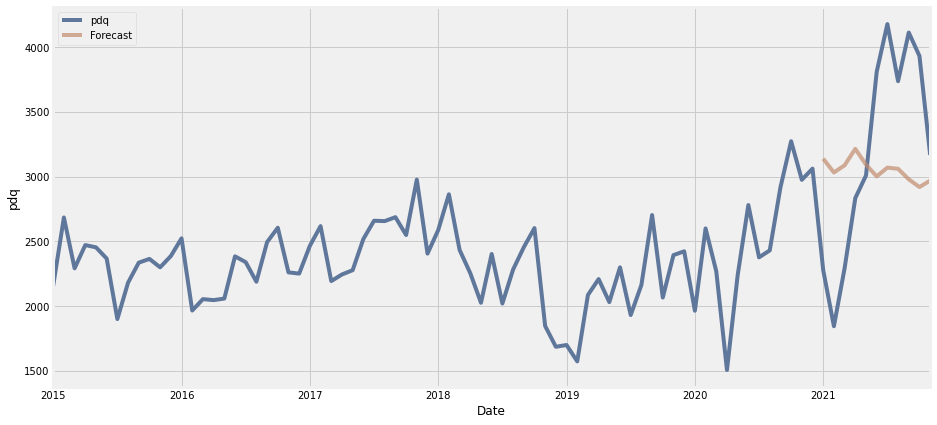

In [16]:
# graficar mejor modelo

preds = best_model['yhat']
ax = df_y['2015':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('pdq')
plt.legend()
plt.show()

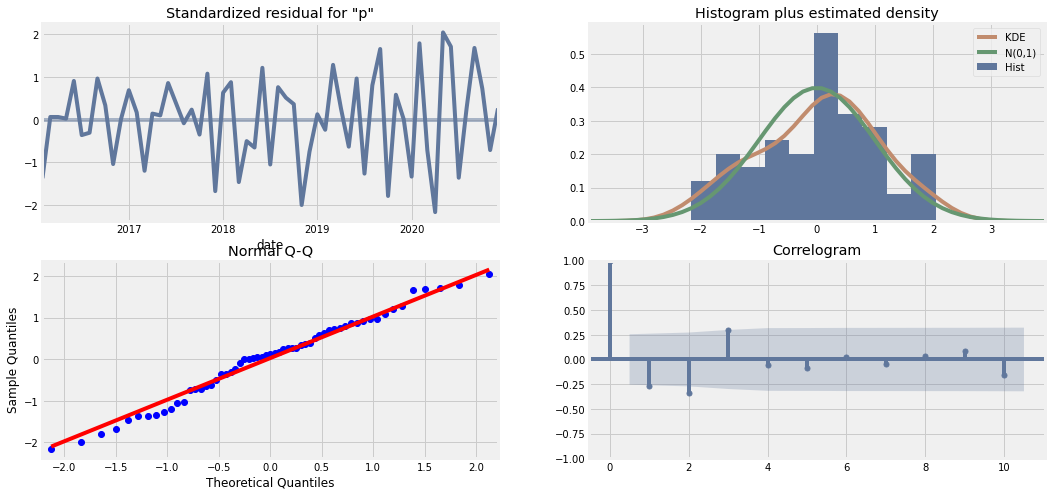

In [17]:
# resultados del error 
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

Segun los gra